## Solving PDEs with the Finite Difference Method

- Datasets in the lesson are available through: [https://www.kaggle.com/datasets/yhzang32/2025-course-dl4pde](https://www.kaggle.com/datasets/yhzang32/2025-course-dl4pde)

## (1) Solving the 1d Poisson equation with FDM
$$
- k\frac{d^2u}{dx^2} = f(x), \quad x \in [0,1]
$$
where $k=0.001$, $f(x)=sin(2\pi x)$ and Dirichlet boundary condition is considered (i.e. $u(0)=u_0, u(1)=u_1$).

### （1.1）The discretization of the PDE
With the second-order derivative approximation, we can discretize the PDE as follows:
\begin{equation}
- k \frac{u_{i+1} - 2u_i + u_{i-1}}{\Delta x^2} = f(x_i), \quad i=1,\cdots,N-1 \tag{1}
\end{equation}


We denote
$$
\vec{u} = [u_1, u_2, \cdots, u_{N-1}]^T,
$$
Then $(1)$ can be formulated as the following linear system: 
\begin{equation}
- \frac{k}{\Delta x^2} \left[
\begin{matrix}
-2 & 1 & \cdots & \cdots \\
1 & -2 & \cdots & \cdots \\
\vdots & \vdots & \ddots & 1 \\
\cdots & \cdots & 1 & -2 \\
\end{matrix}
\right] \vec{u} =
\left[
\begin{matrix}
\frac{k}{\Delta x^2}u_0 \\
0 \\
\cdots \\
0 \\
\frac{k}{\Delta x^2}u_N \\
\end{matrix}
\right] +
\left[
\begin{matrix}
 f(x_1)\\
f(x_2) \\
\cdots \\
f(x_{N-2}) \\
 f(x_{N-1})\\
\end{matrix}
\right]
\end{equation}
We denote it as:
$$
A\tilde{u} = b.
$$
The above system is then solved with the built-in method [```numpy.linalg.solve```](https://numpy.org/doc/2.0/reference/generated/numpy.linalg.solve.html) in ```numpy```.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def get_A(N, kapa, dx):
    '''The matix A'''
    A = np.zeros(shape=(N-1, N-1))
    #
    for j in range(N-1):
        if j>0: # The lower diagonal
            A[j, j-1] = 1 
        A[j, j] = - 2 # The main diagonal
        if j<N-2: # The upper diagonal
            A[j, j+1] = 1

    return - A * kapa / dx**2

def get_b(N, kapa, dx, u0, uN):
    '''The vector b'''
    x = np.linspace(0., 1., N+1)
    b = np.sin(2*np.pi*x[1:-1]) # The right-hand side
    #
    b[0] += kapa * u0 / dx**2   # The left boundary
    b[-1] += kapa * uN / dx**2  # The right boundary

    return b
    
##################################
# The value of kapa and boundary conditions
kapa = 0.001
u0 = 1.
u1 = 1.2
#
N = 100
x_mesh = np.linspace(0, 1, N+1)
dx = x_mesh[1] - x_mesh[0] # the mesh size
#
A = get_A(N, kapa, dx)
b = get_b(N, kapa, dx, u0, u1)
## 
u_fdm = np.zeros(N+1); u_fdm[0] = u0; u_fdm[-1] = u1;
u_fdm[1:-1] = np.linalg.solve(A, b)
print(u_fdm.shape)

(101,)


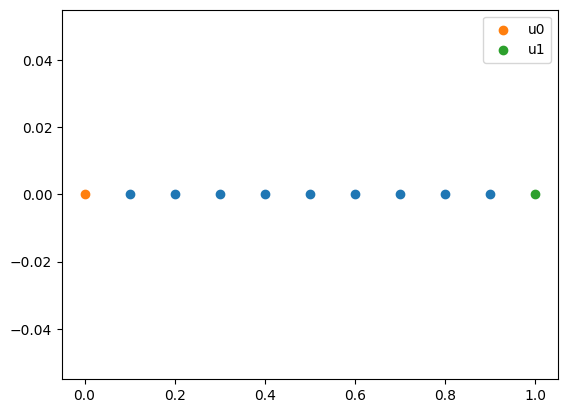

In [2]:
plt.figure()
N_plot = 10
x_plot = np.linspace(0, 1, N_plot+1)
plt.scatter(x_plot[1:-1], np.zeros(N_plot-1))
plt.scatter(x_plot[0], np.array([0.]), label='u0')
plt.scatter(x_plot[-1], np.array([0.]), label='u1')
plt.legend()
plt.show()

### (1.2) Visualize the solution
**Note:** The problem has an explicit solution 
$$u(x) = \frac{\sin(2\pi x)}{4\pi^2k} + (u_1-u_0)x+u_0.$$

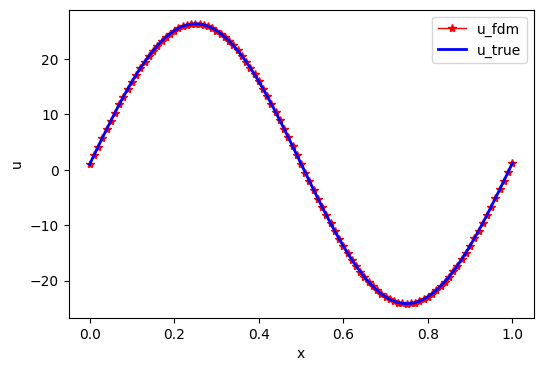

In [3]:
u_true = np.sin(2*np.pi*x_mesh)/(4*np.pi**2*kapa) + (u1-u0) * x_mesh + u0
#
plt.figure(figsize=(6,4))
plt.plot(x_mesh, u_fdm, c='r', marker='*', label='u_fdm', linewidth=1.)
plt.plot(x_mesh, u_true, c='b', label='u_true', linewidth=2.)
#
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.show()

### (1.3) The accuracy 
The relative $L^2$ error between the solution $u_{fdm}$ and the truth $u_{true}$ is defined as follows:
$$
error = \sqrt{\frac{\|u_{fdm}-u_{true}\|^2}{\|u_{true}\|^2}}
$$
#### Relationship between $L^2$ error and step size $\Delta x^2$
$$L^2 \propto \mathcal{O}(\Delta x^2)$$

In [4]:
error = np.sqrt(np.sum((u_true-u_fdm)**2)/np.sum(u_true**2))
print(error)

0.00032925016195290417


In [5]:
class FDM():

    def __init__(self, N=100, kapa=0.001, u0=1., u1=1.2):
        self.x = np.linspace(0, 1, N+1)
        dx = self.x[1]-self.x[0]
        #
        A = self.get_A(N, kapa, dx)
        b = self.get_b(N, kapa, dx, u0, u1)
        #
        self.u_fdm = np.zeros(N+1); 
        self.u_fdm[0] = u0; 
        self.u_fdm[-1] = u1;
        self.u_fdm[1:-1] = np.linalg.solve(A, b)
        
    @property
    def _u(self):
        return self.u_fdm

    @property
    def _x(self):
        return self.x

    def get_A(self, N, kapa, dx):
        '''The matix A'''
        A = np.zeros(shape=(N-1, N-1))
        #
        for j in range(N-1):
            if j>0:
                A[j, j-1] = 1 
            A[j, j] = - 2
            if j<N-2:
                A[j, j+1] = 1
    
        return - A * kapa / dx**2

    def get_b(self, N, kapa, dx, u0, uN):
        '''The vector b'''
        x = np.linspace(0., 1., N+1)
        b = np.sin(2*np.pi*x[1:-1])
        #
        b[0] += kapa * u0 / dx**2 
        b[-1] += kapa * uN / dx**2
    
        return b
#
N_list = [10, 20, 40, 80, 100, 200]
err_list = []
h_list = []
#
kapa=0.001; u0=1.; u1=1.2
for N in N_list:
    sol = FDM(N, kapa, u0, u1)
    u_fdm = sol._u
    x = sol._x
    u_true = np.sin(2*np.pi*x)/(4*np.pi**2*kapa) + (u1-u0) * x + u0
    #
    error = np.sqrt(np.sum((u_true-u_fdm)**2)/np.sum(u_true**2))
    err_list.append(error)
    h_list.append((x[1]-x[0])**2)
#
print(h_list)
print(err_list)

[0.010000000000000002, 0.0025000000000000005, 0.0006250000000000001, 0.00015625000000000003, 0.0001, 2.5e-05]
[0.03357010105065961, 0.008269606059975015, 0.00205988025621735, 0.0005145078224211197, 0.00032925016195290417, 8.230118918717483e-05]


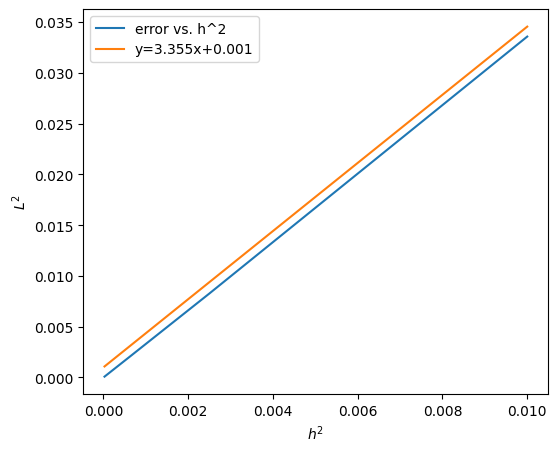

In [6]:
plt.figure(figsize=(6,5))
plt.plot(h_list, err_list, label='error vs. h^2')
plt.plot(np.array(h_list), 3.355*np.array(h_list)+0.001, label='y=3.355x+0.001')
plt.xlabel(r'$h^2$')
plt.ylabel(r'$L^2$')
plt.legend()
plt.show()

### (2) Solving 1D heat equation with Python
$$
\begin{split}
\frac{\partial u}{\partial t} &= k \frac{\partial^2 u}{\partial x^2},\quad (x,t)\in \Omega_T=[0,1]\times[0,1] \\
 u(x,0) &= 0 \\
 u(0,t)=1,&\  u(1,t)=-1 \\
\end{split}
$$
where $k=1.$

### （2.1）The discretization of the PDE
We denote $u_i = u(x_i,t)$ and approximate the PDE as
\begin{equation}
\frac{d u_i}{dt} = k \frac{u_{i+1} - 2u_i + u_{i-1}}{\Delta x^2}, \quad i=1,\cdots,N-1. \tag{9}
\end{equation}
We denote 
$$
\vec{u}(t) = [u_1, u_2, \cdots, u_{N-1}]^T.
$$
Then, the equations $(9)$ can be reformulated as the following linear system:
\begin{equation}
\frac{d \vec{u}(t)}{dt} =
\frac{k}{\Delta x^2}\left[
\begin{matrix}
-2 & 1 & \cdots & \cdots \\
1 & -2 & \cdots & \cdots \\
\vdots & \vdots & \ddots & 1\\
\cdots & \cdots & 1, & -2 \\
\end{matrix}
\right] \vec{u}
+
\left[
\begin{matrix}
\frac{k}{\Delta x^2}u_0 \\
0 \\
\cdots \\
0 \\
\frac{k}{\Delta x^2}u_N \\
\end{matrix}
\right] 
\end{equation}
We denote it as:
$$
\frac{d\tilde{u}}{dt} = A\tilde{u} + b.
$$
The above ODE system is solved with the built-in method [```solve_ivp```](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) in ```scipy.integrate```.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def get_A(N, kapa, dx):
    '''The matix A'''
    A = np.zeros(shape=(N-1, N-1))
    #
    for j in range(N-1):
        if j>0: # The lower diagonal
            A[j, j-1] = 1 
        A[j, j] = - 2 # The main diagonal
        if j<N-2: # The upper diagonal
            A[j, j+1] = 1

    return A * kapa/ dx**2

def get_b(N, kapa, dx, u0, uN):
    '''The vector b'''
    b = np.zeros(N-1)
    #
    b[0] = kapa * u0 / dx**2  # The left boundary
    b[-1] = kapa * uN / dx**2 # The right boundary

    return b
    
##################################
# The value of kapa and boundary conditions
kapa = 1.
u0 = 1.
uN = -1.
#
N = 100
x_mesh = np.linspace(0, 1, N+1)
dx = x_mesh[1] - x_mesh[0]
#
A = get_A(N, kapa, dx)
b = get_b(N, kapa, dx, u0, uN)
## 
F = lambda t, u: np.dot(A, u) + b
u_init = np.zeros(N-1)
t_mesh = np.linspace(0., 1., 1001)
sol = solve_ivp(F, t_span=[0,1], y0=u_init, t_eval=t_mesh)
#
print(sol.t.shape)
print(sol.y.shape)

(1001,)
(99, 1001)


#### Visualization

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots()
line, = ax.plot(x_mesh[1:-1], sol.y[:,0])

def animate(i):
    line.set_ydata(sol.y[:,i])
    ax.set_ylim(-1.1, 1.1)
    
    return line,

ani = animation.FuncAnimation(fig, animate, frames=500, interval=10, blit=True)
HTML(ani.to_jshtml())

#### Comparison with the result obtained by Matlab built-in algorithm

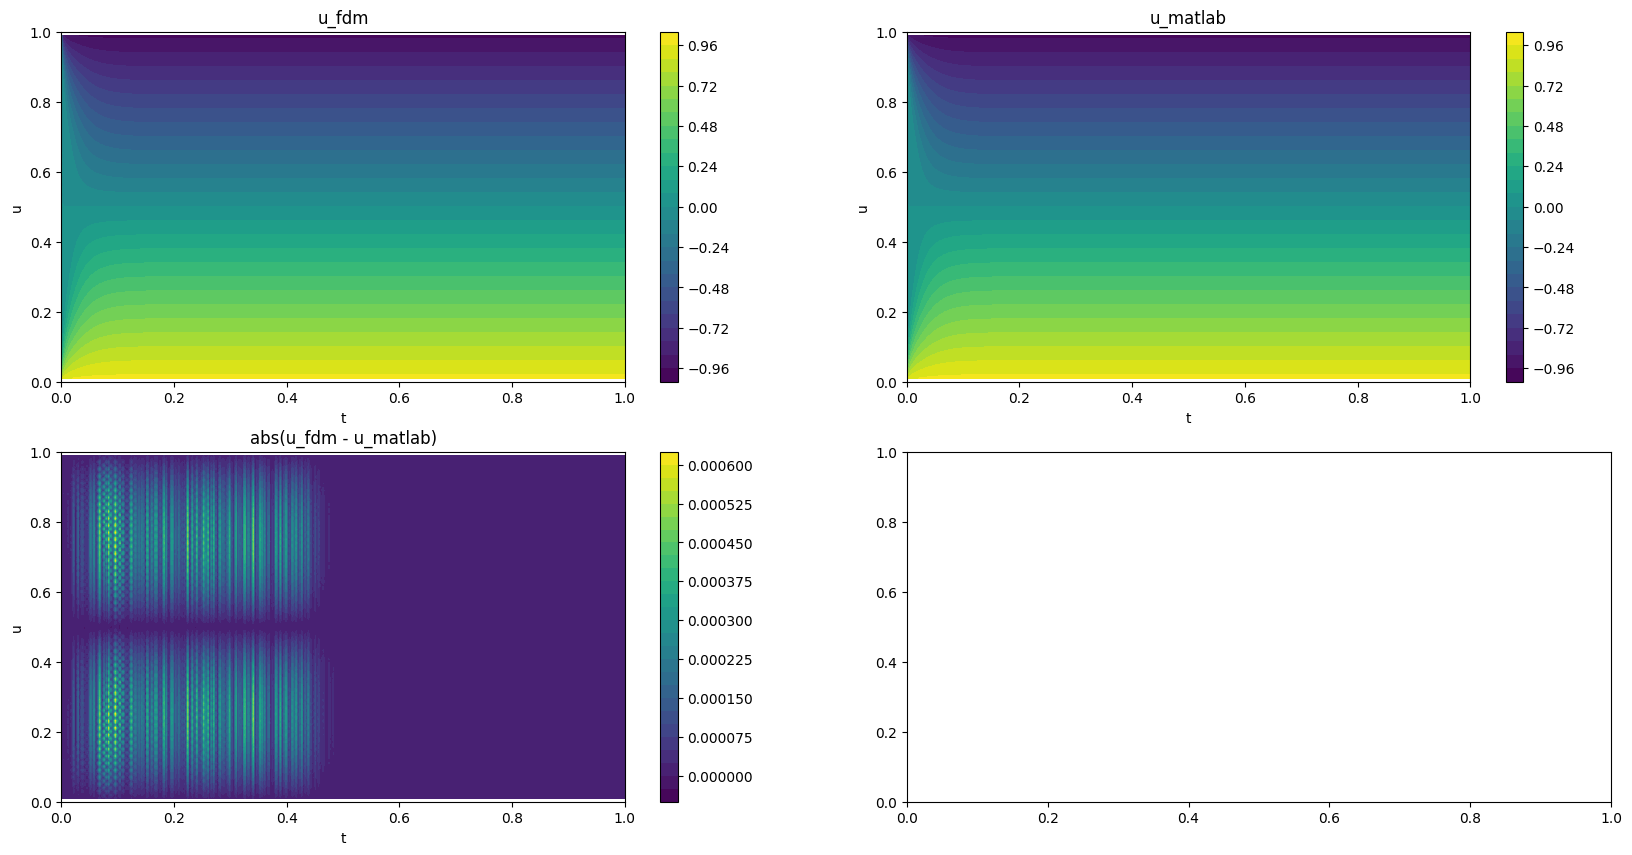

In [9]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

## Load the result obtained by Matlab
with h5py.File('heat_1d.h5', 'r') as f:
    u_true = np.array(f['sol'])[1:-1]
#
u_fdm = sol.y
# Mesh for plotting
tt, xx = np.meshgrid(t_mesh, x_mesh[1:-1])
tx = np.stack([tt.flatten(), xx.flatten()]).T
#
grid_t, grid_x = np.mgrid[0:1:500j, 0:1:200j] 

# Plottings
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
grid_z = griddata((tx[:,0], tx[:,1]), u_fdm.flatten(), (grid_t, grid_x), method='cubic') 
cntr1 = axes[0,0].contourf(grid_t, grid_x, grid_z, levels=30, cmap="viridis")  # Filled contour plot
axes[0,0].set_xlabel("t")
axes[0,0].set_ylabel("u")
axes[0,0].set_title("u_fdm")
plt.colorbar(cntr1)
#
grid_z = griddata((tx[:,0], tx[:,1]), u_true.flatten(), (grid_t, grid_x), method='cubic') 
cntr2 = axes[0,1].contourf(grid_t, grid_x, grid_z, levels=30, cmap="viridis")  # Filled contour plot
axes[0,1].set_xlabel("t")
axes[0,1].set_ylabel("u")
axes[0,1].set_title("u_matlab")
plt.colorbar(cntr2)
#
grid_z = griddata((tx[:,0], tx[:,1]), np.abs(u_true-u_fdm).flatten(), (grid_t, grid_x), method='cubic') 
cntr3 = axes[1,0].contourf(grid_t, grid_x, grid_z, levels=30, cmap="viridis")  # Filled contour plot
axes[1,0].set_xlabel("t")
axes[1,0].set_ylabel("u")
axes[1,0].set_title("abs(u_fdm - u_matlab)")
plt.colorbar(cntr3)
#
plt.show()

### (3) Summary

In [ ]:
1, regular geometries
2, more grids, more accurate
3, numerical approximation for approximating derivatives
4, need interpolation to make predictions on random positions
5, curse-of-dimensionality

## Exercises

### Task 1: Solving the 1D Darcy’s Flow Problem with FDM

#### Problem Statement

Darcy’s law describes the flow of a fluid through a porous medium. In 1D, it is given by the steady-state equation:
$$
-\frac{d}{dx} \left( k(x) \frac{d p}{dx} \right) = f(x), \quad x \in [0,1]
$$
where:
- $p(x)$ is the pressure (unknown),
- $k(x)= (1 + \sin(\frac{3\pi}{2}x))/3$ is the permeability of the medium,
- $f(x)=\frac{3\pi^2}{4}(\cos(\frac{3\pi}{2}x)+\sin(3\pi x))$ is an external source term.

We impose Dirichlet boundary conditions:
$$
p(0) = 1, \quad p(1) = 0
$$

#### Discretization Using Finite Difference Method (FDM)

Using a uniform grid with N points and spacing $\Delta x$, we approximate:
$$
\begin{split}
\frac{d}{dx} \left( k(x) \frac{d p}{dx} \right) &\approx \frac{1}{\Delta x} \left[ k_{i+1/2} \frac{p_{i+1} - p_i}{\Delta x} - k_{i-1/2} \frac{p_i - p_{i-1}}{\Delta x} \right] \\
 & = \frac{1}{\Delta x^2}\left[k_{i+1/2} p_{i+1} -(k_{i+1/2}+k_{i-1/2})p_i + k_{i-1/2}p_{i-1} \right]
\end{split}
$$
where $k_{i+1/2}=\frac{k_i +k_{i+1}}{2}$ and $k_{i-1/2}=\frac{k_i+k_{i-1}}{2}$. Rearranging, we get a linear system:
$$
A \mathbf{p} = \mathbf{b}
$$
where:
- $A$ is a tridiagonal matrix,
- $\mathbf{p}$ is the vector of unknown pressures,
- $\mathbf{b}$ is the right-hand side including $f(x)$ and boundary conditions.

### Task2: Solving the 2d Poisson Equation using FDM

#### The 2d Poisson Equation

The Poisson equation models steady-state problems in physics, such as electrostatics and heat conduction:
$$
-\nabla^2 u = - \left(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2}\right) = f(x, y), \quad (x,y) \in \Omega
$$
where $f(x,y)=2\pi^2\sin(\pi x)\sin(\pi y)$ and Dirichlet boundary condition is considered:
$$
u(x,y) = 0, \quad (x,y) \in \partial \Omega
$$

#### Numerical Discretization (Finite Difference Method)

Using central difference approximation, we discretize the Laplace operator on a uniform grid with $(N+2) \times (N+2)$ points:
$$
- \left(\frac{u_{i-1,j} - 2u_{i,j} + u_{i+1,j}}{\Delta x^2} + \frac{u_{i,j-1} - 2u_{i,j} + u_{i,j+1}}{\Delta y^2}\right)= f_{i,j}
$$
For a uniform grid $\Delta x = \Delta y = h$, the equation simplifies to:
$$
-\frac{1}{h^2}\left(u_{i+1,j} + u_{i-1,j} + u_{i,j+1} + u_{i,j-1} - 4u_{i,j}\right) =f_{i,j}.
$$

<center>
    <img src="../Figures/PDE_FDM_grid.jpg" width = "500" height='600' alt=""/>
    <br>
    <div style="color:gray">
      <b>Fig. 1:</b> Illustration of the Grid and Stencil
  	</div>
</center>

This forms a linear system:
$$
A u = b
$$
where:
- $A$ is a sparse block-tridiagonal matrix of size $N^2 \times N^2$,
- $\vec{u}=[u_{1,1},\cdots,u_{1,N},\cdots,u_{N,1},\cdots,u_{N,N}]$ is the unknown solution vector,
- $b$ is the right-hand side containing $f(x,y)$.

**Example for N=3 (3x3 interior grid):**

For a $3 \times 3$ interior grid, the unknown vector $u$ is ordered as:
$$
u = [u_{1,1}, u_{1,2}, u_{1,3}, u_{2,1}, u_{2,2}, u_{2,3}, u_{3,1}, u_{3,2}, u_{3,3}]
$$
The corresponding matrix $A$ is:
$$
A = -\frac{1}{h^2}
\begin{bmatrix}
-4 & 1  & 0  & 1  & 0  & 0  & 0  & 0  & 0  \\
1  & -4 & 1  & 0  & 1  & 0  & 0  & 0  & 0  \\
0  & 1  & -4 & \color{red}{0}  & 0  & 1  & 0  & 0  & 0  \\
1  & 0  & \color{red}{0}  & -4 & 1  & 0  & 1  & 0  & 0  \\
0  & 1  & 0  & 1  & -4 & 1  & 0  & 1  & 0  \\
0  & 0  & 1  & 0  & 1  & -4 & \color{red}{0}  & 0  & 1  \\
0  & 0  & 0  & 1  & 0  & \color{red}{0}  & -4 & 1  & 0  \\
0  & 0  & 0  & 0  & 1  & 0  & 1  & -4 & 1  \\
0  & 0  & 0  & 0  & 0  & 1  & 0  & 1  & -4 \\
\end{bmatrix}
$$

#### Steps to Solve the Problem
- **Discretize the domain** with grid spacing $h = \frac{1}{N+1}$.
- Assemble the finite difference **matrix A**.
- Construct the right-hand side **vector b**.
- **Solve the linear system $Au = b$** using an iterative solver (e.g., Conjugate Gradient) or a direct solver (e.g., LU decomposition).
- **Visualize the solution $u(x,y)$** using contour and surface plots.